# Curso de manejo de datos faltantes: Imputación

## Configuración del ambiente de trabajo

### Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar funciones personalizadas

In [2]:
%run ../context/0_pandas-missing-extension.ipynb

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


### Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

### El problema de trabajar con valores faltantes

In [4]:
aq_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type = 'snake'
    )
    .add_column('year', 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by = 'date')
    .set_index('date')
)

aq_df

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula='temp ~ ozone', 
        data = aq_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Mon, 09 Oct 2023",Prob (F-statistic):,2.93e-18
Time:,15:44:34,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r', 
        data = aq_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Mon, 09 Oct 2023",Prob (F-statistic):,1.47e-16
Time:,15:44:34,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


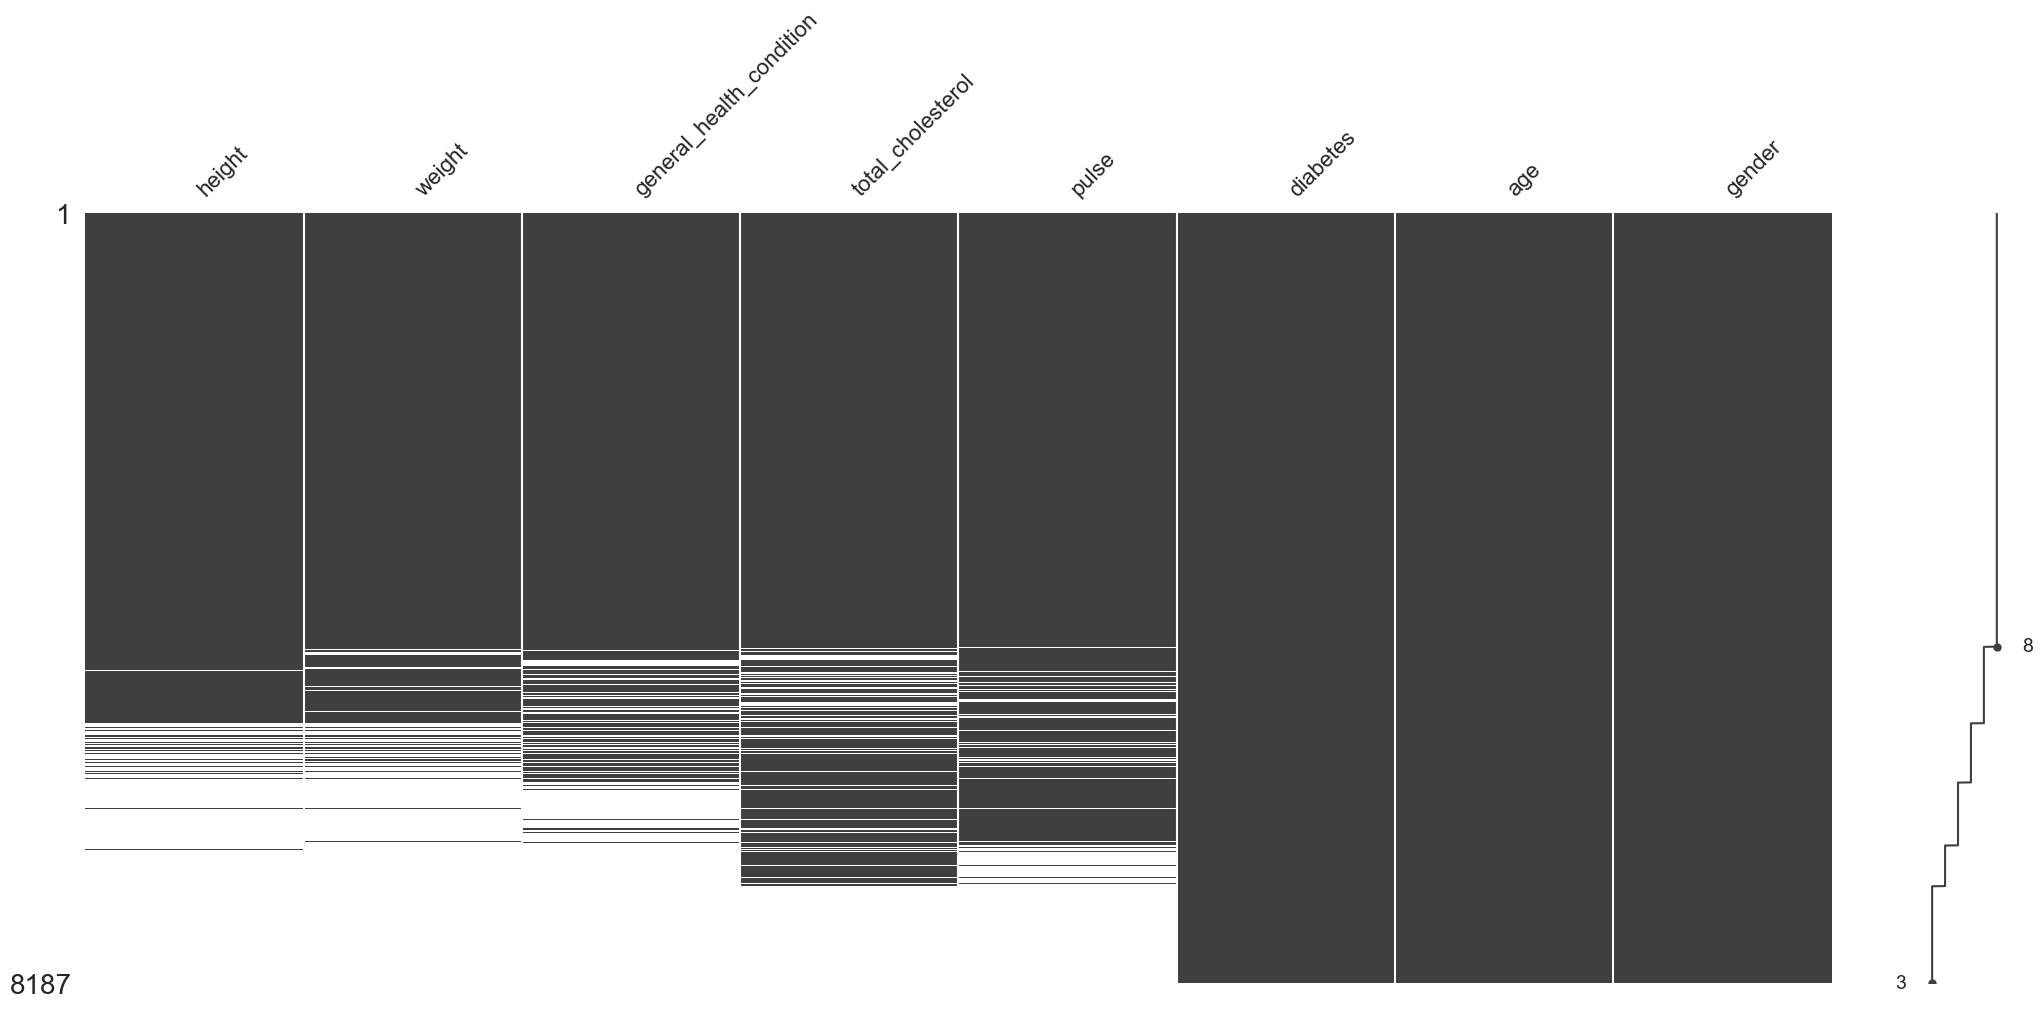

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


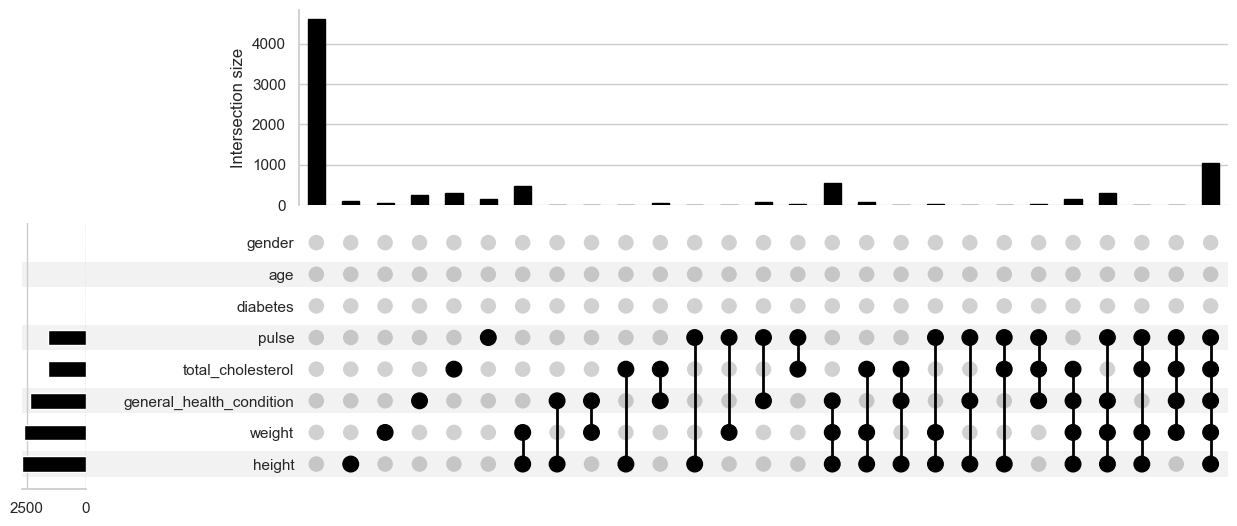

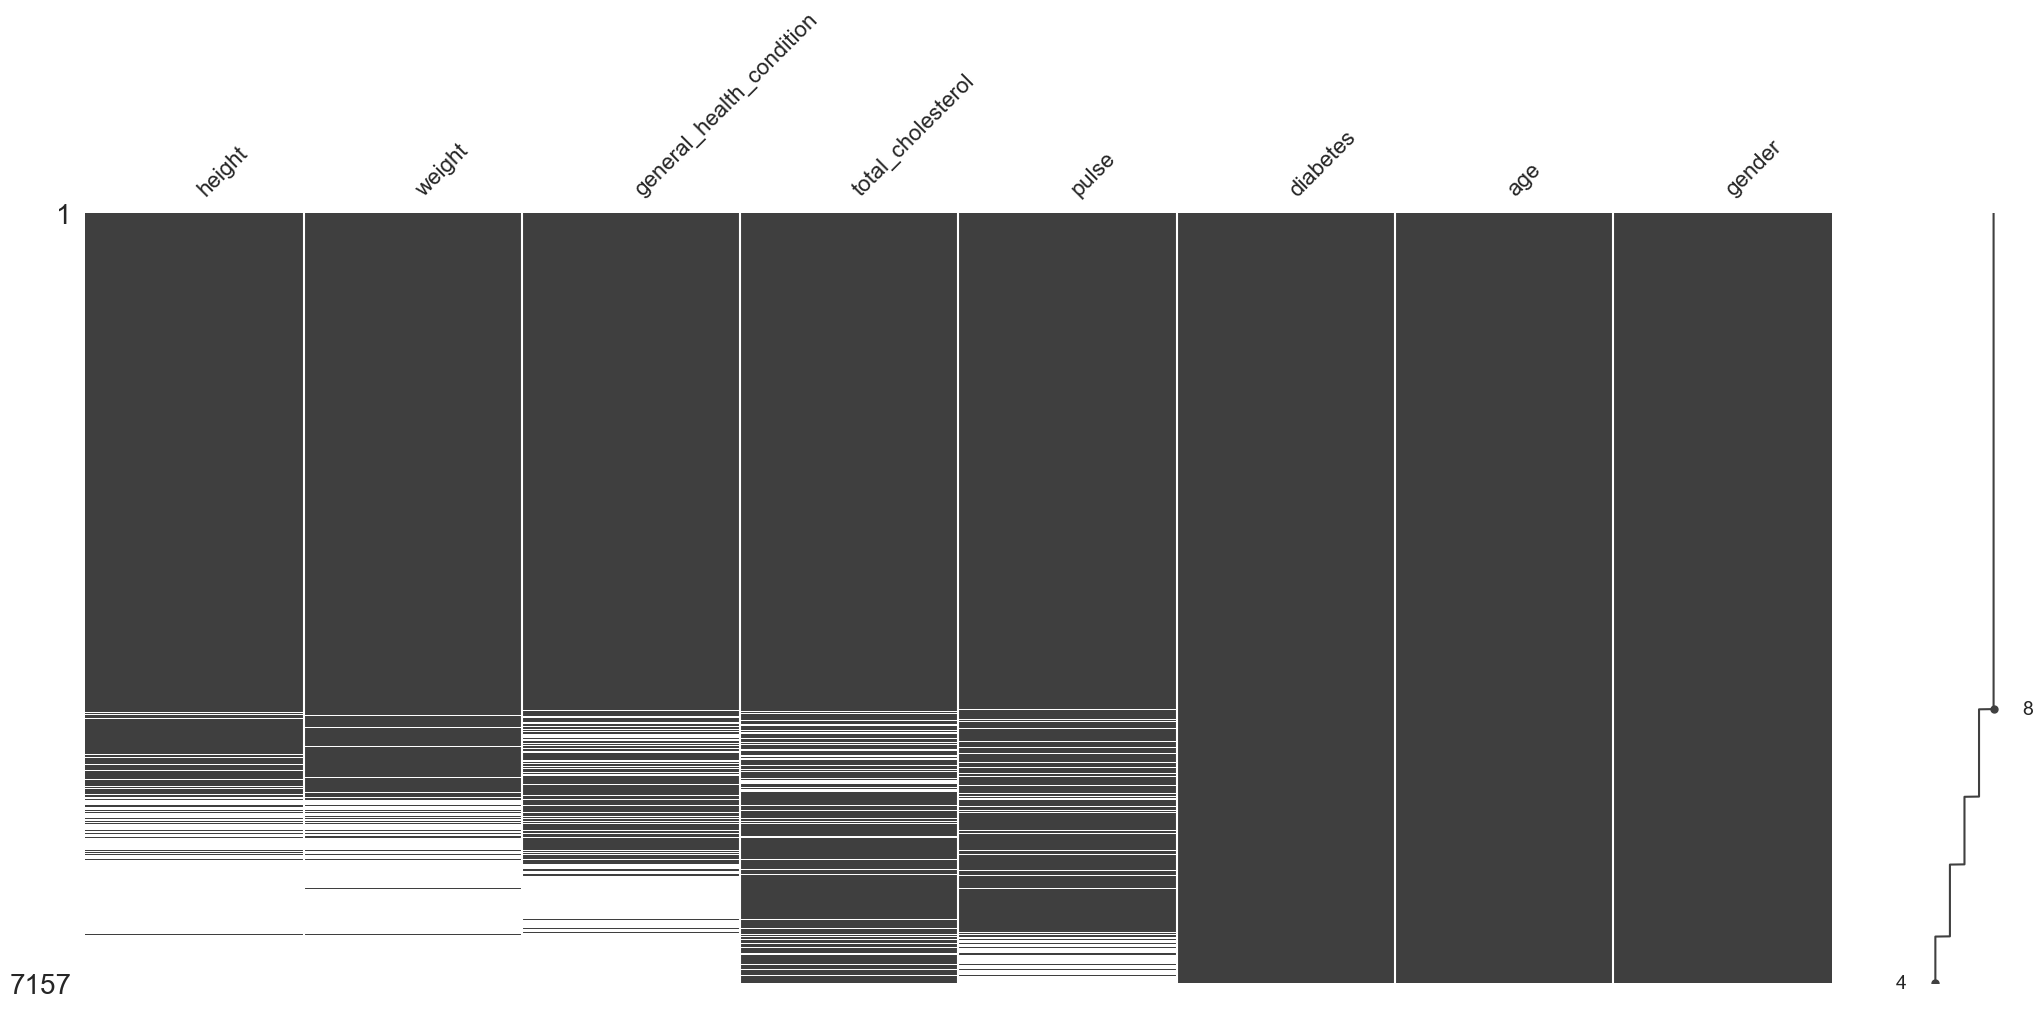

In [7]:
%run ../context/4_download-data-and-load-it.ipynb

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [8]:
nhanes_df.reset_index(inplace=True)
nhanes_df

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...,...
7152,102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
7153,102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
7154,102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female
7155,102955.0,NaN,NaN,Very good,150.0,74.0,0,14.0,Female


In [9]:
female_weight, male_weight = (
    nhanes_df
    .select_columns('gender', 'weight')
    .transform_column(
        'weight',
        # El valor de peso es faltante? 
        lambda x : x.isna(),
        # Para que regrese una serie
        elementwise = False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df : (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

# Haciendo una prueba estadistica para establecer si existe o no, una presencia o asuencia de valores de peso 
# ¿Existe una diferencia entre la presencia o ausencia de valores de mediciòn de peso?
# Si el pvalor es mayor a 0.05, no podemos aceptar ni rechazar la hipotesis nula de que exista una diferencia 
# El pvalor = 0.71, no podriamos rechazar nuestra hipotesis nula, es decir, no podemos decir que existe una diferecia entre las personas que tienen valores faltantes
# Con esto se podria decir que nuestros valores no estan perdidos al azar, al menos en las categorias 'female' y 'male'
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight, 
    alternative = 'two-sided'
)

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

In [10]:
female_weight

0       False
3       False
7       False
12       True
13      False
        ...  
7145     True
7146    False
7151    False
7154    False
7155     True
Name: weight, Length: 3665, dtype: bool

In [11]:
male_weight

1       False
2        True
4       False
5       False
6       False
        ...  
7149    False
7150    False
7152    False
7153    False
7156    False
Name: weight, Length: 3492, dtype: bool

## Amplía tu conjunto de herramientas para explorar valores faltantes

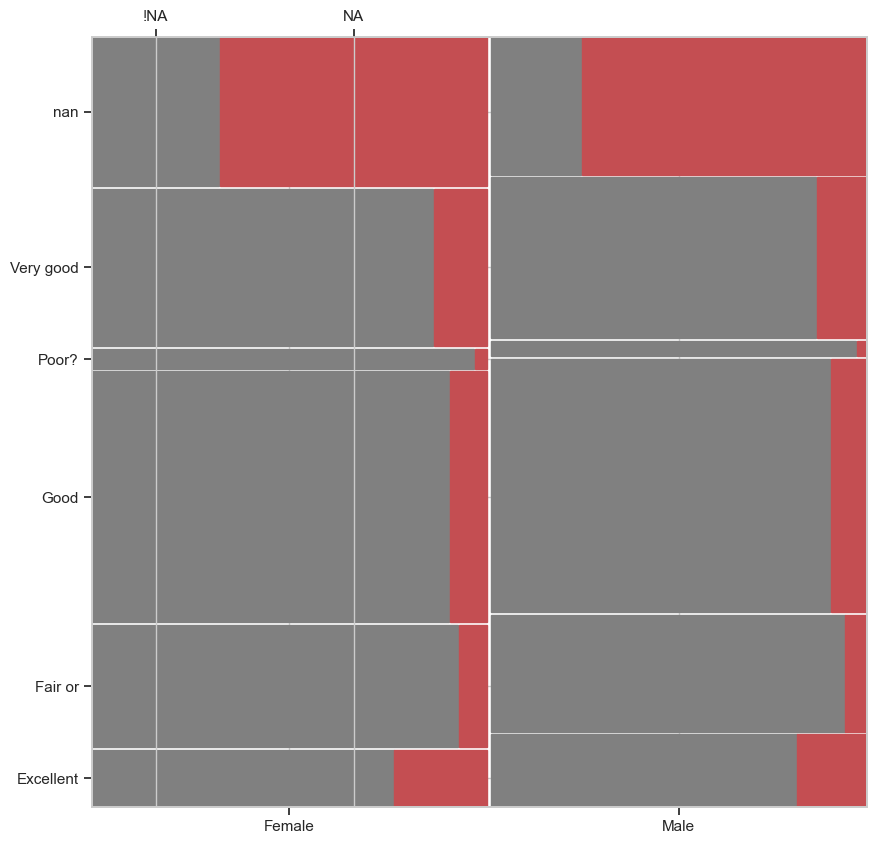

In [12]:
fig, ax = plt.subplots(figsize = (10,10))

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    # Reemplezando la informacion en la columna 'weight' por si hay null o no null
    .assign(
        weight = lambda df : df['weight'].isna().replace([True, False], ['NA', '!NA'])
    )
    # Cuantificar cuantas apariciones existe por cada combinaciòn de estas 3 columnas
    .groupby(
        ['gender', 'general_health_condition', 'weight'], 
        dropna = False, 
        as_index = True
    )
    .size()
    # Grafico de mosaicos, permite visualizar este tipo de relaciones en las cuales nosotros tenemos conteos de diferentes variables categoricas
    # Con diferentes subniveles 
    .pipe(
        lambda df : mosaic(
            data = df,
            properties = lambda key : {'color' : 'r' if 'NA' in key else 'gray'},
            horizontal = True,
            axes_label = True,
            title = '',
            labelizer = lambda key : '',
            ax = ax
        )
    )
);

In [13]:
def missing_mosaic_plot(
        self,
        target_var : str,
        x_categorical_var : str,
        y_categorical_var : str,
        ax = None
): 
    return(
        self._obj
        .assign(
            {target_var : lambda df : df['weight'].isna().replace([True, False], ['NA', '!NA'])}
        )
        .groupby(
            [x_categorical_var, y_categorical_var, target_var], dropna = False, as_index = True
        )
        .size()
        .pipe(
            lambda df : mosaic(
                data = df,
                properties = lambda key : {'color':'r' if 'NA' in key else 'gray'},
                ax = ax,
                horizontal = True,
                axes_label = True,
                tite = '',
                labelizer = lambda key : '',
            )
        )
    )

## Tratamiento de variables categóricas para imputación de valores faltantes

In [14]:
nhanes_transformed_df = nhanes_df.copy(deep=True)
nhanes_transformed_df

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...,...
7152,102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
7153,102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
7154,102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female
7155,102955.0,NaN,NaN,Very good,150.0,74.0,0,14.0,Female


### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>

    LabelEncoder
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [15]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [['Male'], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [16]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [17]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [18]:
encoder.inverse_transform([[1],[0], [1]])

array([['Male'],
       ['Female'],
       ['Male']], dtype=object)

### Aplicando la codificación ordinal a todas tus variables categóricas

In [19]:
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [20]:
# Función de sklearn que nos permite componer instrucciones de transformación de nuestros datos 
categorical_transformer = sklearn.compose.make_column_transformer(
    # Tupla, transformador que queremos hacer y los nombres de las columnas que queremos que se transformen en nuestro conjunto de datos 
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    # se ignoran las otras variables
    remainder = 'passthrough'
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [21]:
# Creando un nuevo DF
nhanes_transformed_df = (
    pd.DataFrame(
        # Ajustar nuestros datos y transformalos en un solo paso
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x : x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('remainder__')
    )
)

nhanes_transformed_df

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,NaN,NaN,150.0,74.0,0.0,14.0


In [22]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1)
)

(
    gender_encoder
    .fit_transform(
        X = gender_values
        )
        .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transformed_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])

### _One hot encoding_

In [23]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)
nhanes_transformed_df2 

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...,...
7152,102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
7153,102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
7154,102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female
7155,102955.0,NaN,NaN,Very good,150.0,74.0,0,14.0,Female


#### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

##### `pandas.get_dummies()`

In [24]:
(
    nhanes_transformed_df2
    .select_columns('general_health_condition')
    # Pone el nombre de la categoria como columna, 1: el registro cumple con la categoria, 0: el registro NO cumple con la categoria
    #.head(10)
    .pipe(pd.get_dummies)
    # ¿Qué pasa con los valores faltantes? NO se pueden representar :(
    # pandas.get_dummies() NO es por lo general una buena opción
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
7152,1,0,0,0,0
7153,0,1,0,0,0
7154,0,0,1,0,0
7155,0,0,0,0,1


##### `skelearn.preprocessing.OneHotEncoder()`

In [25]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['gender']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['general_health_condition'])])

In [26]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df2

c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\usuario\Desktop\DS\14_Datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,1.0,1.0,0.0,0.0,0.0,0.0,0.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,0.0,1.0,0.0,0.0,0.0,0.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,0.0,0.0,0.0,1.0,0.0,0.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,0.0,0.0,0.0,0.0,0.0,1.0,0.0,102955.0,NaN,NaN,150.0,74.0,0.0,14.0


In [27]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [28]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

## Tipo de imputación de valores faltantes

### Imputacion de un único valor (media, mediana, moda)

In [29]:
(
    nhanes_df
    # De la libreria janitor
    .transform_column(
        # Nombre de la columna a transformar
        'height',
        # Funciòn que llena los valores faltantes con la media, mediana o moda (depende de lo que màs sea conveniente)
        lambda x : x.fillna(x.mean()),
        # Se especifica si se quiere para cada elemento o  no, se coloca 'False', lo que sea x es una columna o serie de datos
        elementwise = False
    )
    .height
    .mean()
)

66.25655976676386

In [30]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False)
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
)

,height,weight,height_NA,weight_NA
0,63.00000,165.000000,False,False
1,68.00000,145.000000,False,False
2,66.25656,178.462993,True,True
3,62.00000,200.000000,False,False
4,69.00000,142.000000,False,False
...,...,...,...,...
7152,72.00000,180.000000,False,False
7153,65.00000,218.000000,False,False
7154,66.00000,150.000000,False,False
7155,66.25656,178.462993,True,True


In [31]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False)
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    )
)

,height,weight,height_NA,weight_NA
0,63.0,165.0,False,False
1,68.0,145.0,False,False
2,66.0,170.0,True,True
3,62.0,200.0,False,False
4,69.0,142.0,False,False
...,...,...,...,...
7152,72.0,180.0,False,False
7153,65.0,218.0,False,False
7154,66.0,150.0,False,False
7155,66.0,170.0,True,True


In [32]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False)
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    )
)

,height,weight,height_NA,weight_NA
0,63.0,165.0,False,False
1,68.0,145.0,False,False
2,NaN,NaN,True,True
3,62.0,200.0,False,False
4,69.0,142.0,False,False
...,...,...,...,...
7152,72.0,180.0,False,False
7153,65.0,218.0,False,False
7154,66.0,150.0,False,False
7155,NaN,NaN,True,True


## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [33]:
(
    nhanes_df
    .select_columns('height', 'weight')
    .fillna(method='ffill')
)

,height,weight
0,63.0,165.0
1,68.0,145.0
2,68.0,145.0
3,62.0,200.0
4,69.0,142.0
...,...,...
7152,72.0,180.0
7153,65.0,218.0
7154,66.0,150.0
7155,66.0,150.0


In [34]:
(
    nhanes_df
    .select_columns('height', 'weight')
    .ffill()
)

,height,weight
0,63.0,165.0
1,68.0,145.0
2,68.0,145.0
3,62.0,200.0
4,69.0,142.0
...,...,...
7152,72.0,180.0
7153,65.0,218.0
7154,66.0,150.0
7155,66.0,150.0


In [35]:
(
    nhanes_df
    .select_columns('height', 'weight')
    .bfill()
)

,height,weight
0,63.0,165.0
1,68.0,145.0
2,62.0,200.0
3,62.0,200.0
4,69.0,142.0
...,...,...
7152,72.0,180.0
7153,65.0,218.0
7154,66.0,150.0
7155,69.0,250.0


### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`
> Imputación dentro de dominios e imputación a través de varaibles correlacionadas

In [36]:
# Imputaciones dentro de los dominios
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'diabetes', 'general_health_condition')
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'], 
        ascending = True
    )
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise = False
    )
)

,height,weight,gender,diabetes,general_health_condition
569,56.0,115.0,Female,0,Excellent
384,59.0,130.0,Female,0,Excellent
1242,59.0,162.0,Female,0,Excellent
3319,59.0,130.0,Female,0,Excellent
4204,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
2238,74.0,290.0,Male,1,NaN
2535,NaN,175.0,Male,1,NaN
2793,NaN,175.0,Male,1,NaN
3239,NaN,175.0,Male,1,NaN


In [37]:
# Imputaciones dentro de los dominios
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'diabetes', 'general_health_condition')
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'], 
        ascending = True
    )
    .transform_column(
        'weight',
        lambda x: x.bfill(),
        elementwise = False
    )
)

,height,weight,gender,diabetes,general_health_condition
569,56.0,115.0,Female,0,Excellent
384,59.0,130.0,Female,0,Excellent
1242,59.0,162.0,Female,0,Excellent
3319,59.0,130.0,Female,0,Excellent
4204,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
2238,74.0,290.0,Male,1,NaN
2535,NaN,175.0,Male,1,NaN
2793,NaN,NaN,Male,1,NaN
3239,NaN,NaN,Male,1,NaN


In [38]:
# Imputaciones dentro de los dominios
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'diabetes', 'general_health_condition')
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'], 
        ascending = True
    )
    .groupby(['gender', 'general_health_condition'], dropna=False)
    .apply(lambda x: x.ffill())
)

C:\Users\usuario\AppData\Local\Temp\ipykernel_8432\1154092581.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.ffill())


,height,weight,gender,diabetes,general_health_condition
569,56.0,115.0,Female,0,Excellent
384,59.0,130.0,Female,0,Excellent
1242,59.0,162.0,Female,0,Excellent
3319,59.0,130.0,Female,0,Excellent
4204,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
2238,74.0,290.0,Male,1,NaN
2535,74.0,175.0,Male,1,NaN
2793,74.0,175.0,Male,1,NaN
3239,74.0,175.0,Male,1,NaN


In [39]:
# Imputaciones dentro de los dominios
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'diabetes', 'general_health_condition')
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'], 
        ascending = True
    )
    .groupby(['gender', 'general_health_condition'], dropna=False)
    .apply(lambda x: x.bfill())
)

C:\Users\usuario\AppData\Local\Temp\ipykernel_8432\2741787204.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.bfill())


,height,weight,gender,diabetes,general_health_condition
569,56.0,115.0,Female,0,Excellent
384,59.0,130.0,Female,0,Excellent
1242,59.0,162.0,Female,0,Excellent
3319,59.0,130.0,Female,0,Excellent
4204,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
2238,74.0,290.0,Male,1,NaN
2535,NaN,175.0,Male,1,NaN
2793,NaN,NaN,Male,1,NaN
3239,NaN,NaN,Male,1,NaN


## Imputación por interpolación

In [40]:
aq_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


<Axes: xlabel='date'>

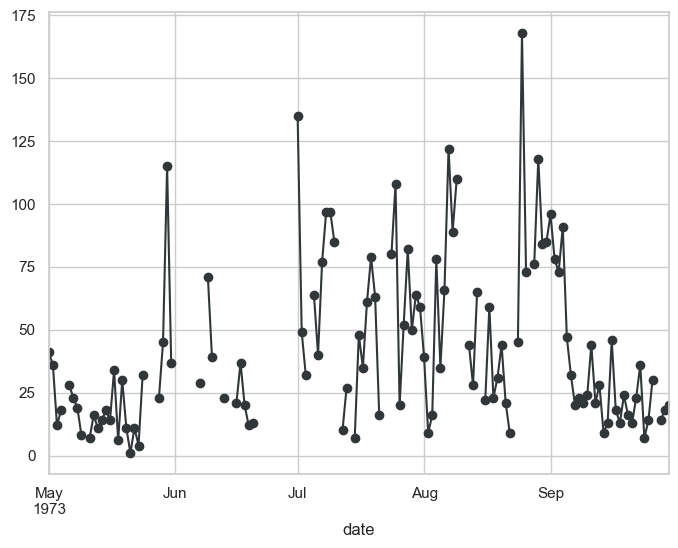

In [41]:
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

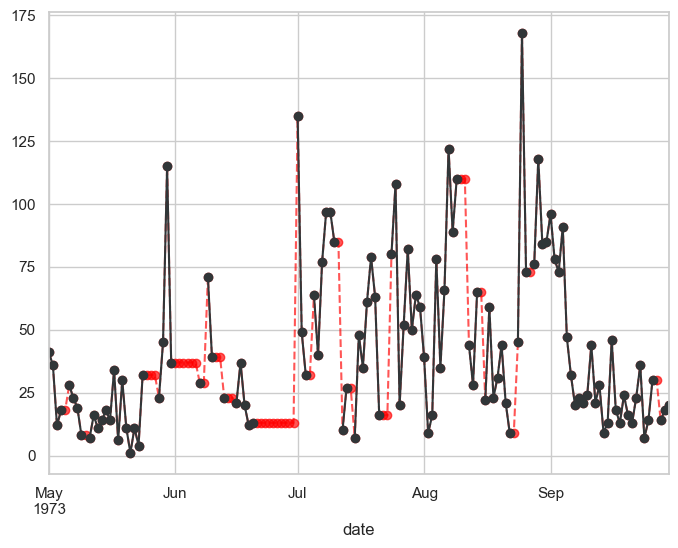

In [42]:
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

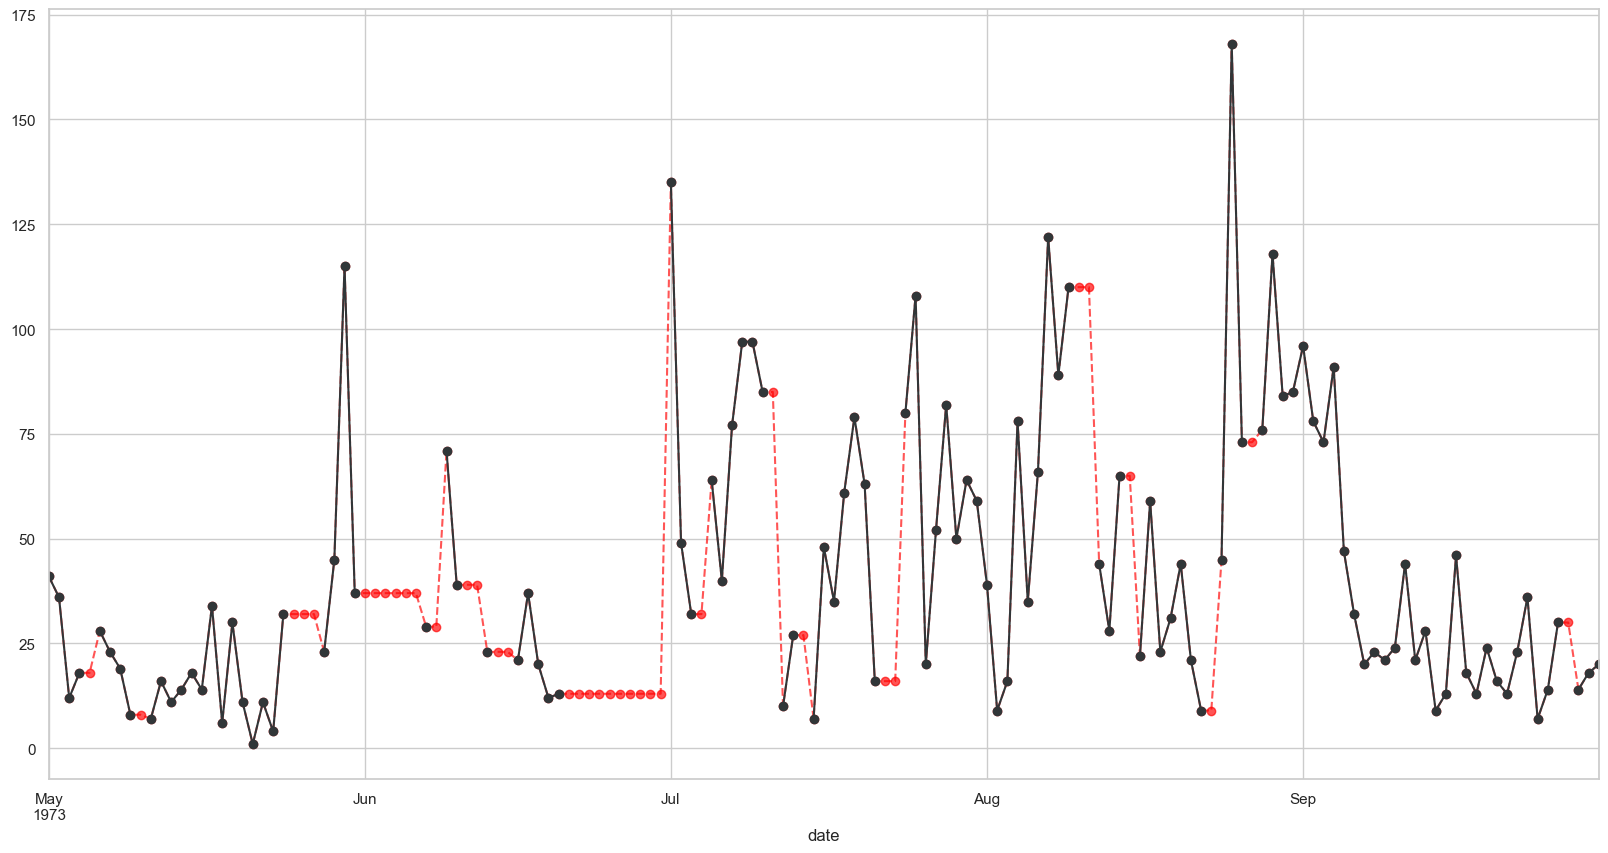

In [43]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

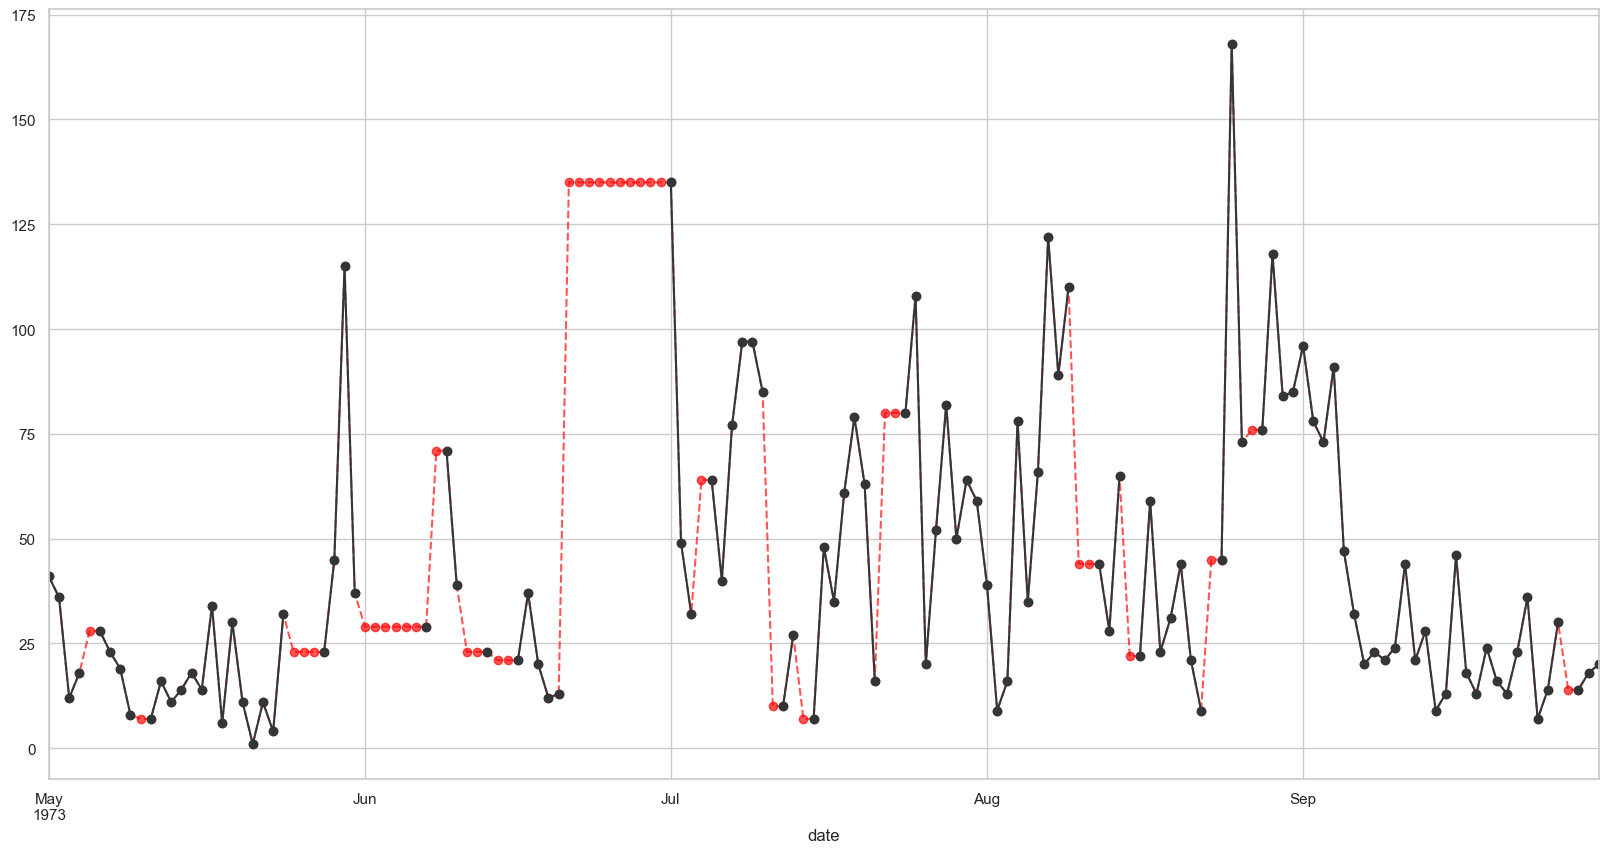

In [44]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

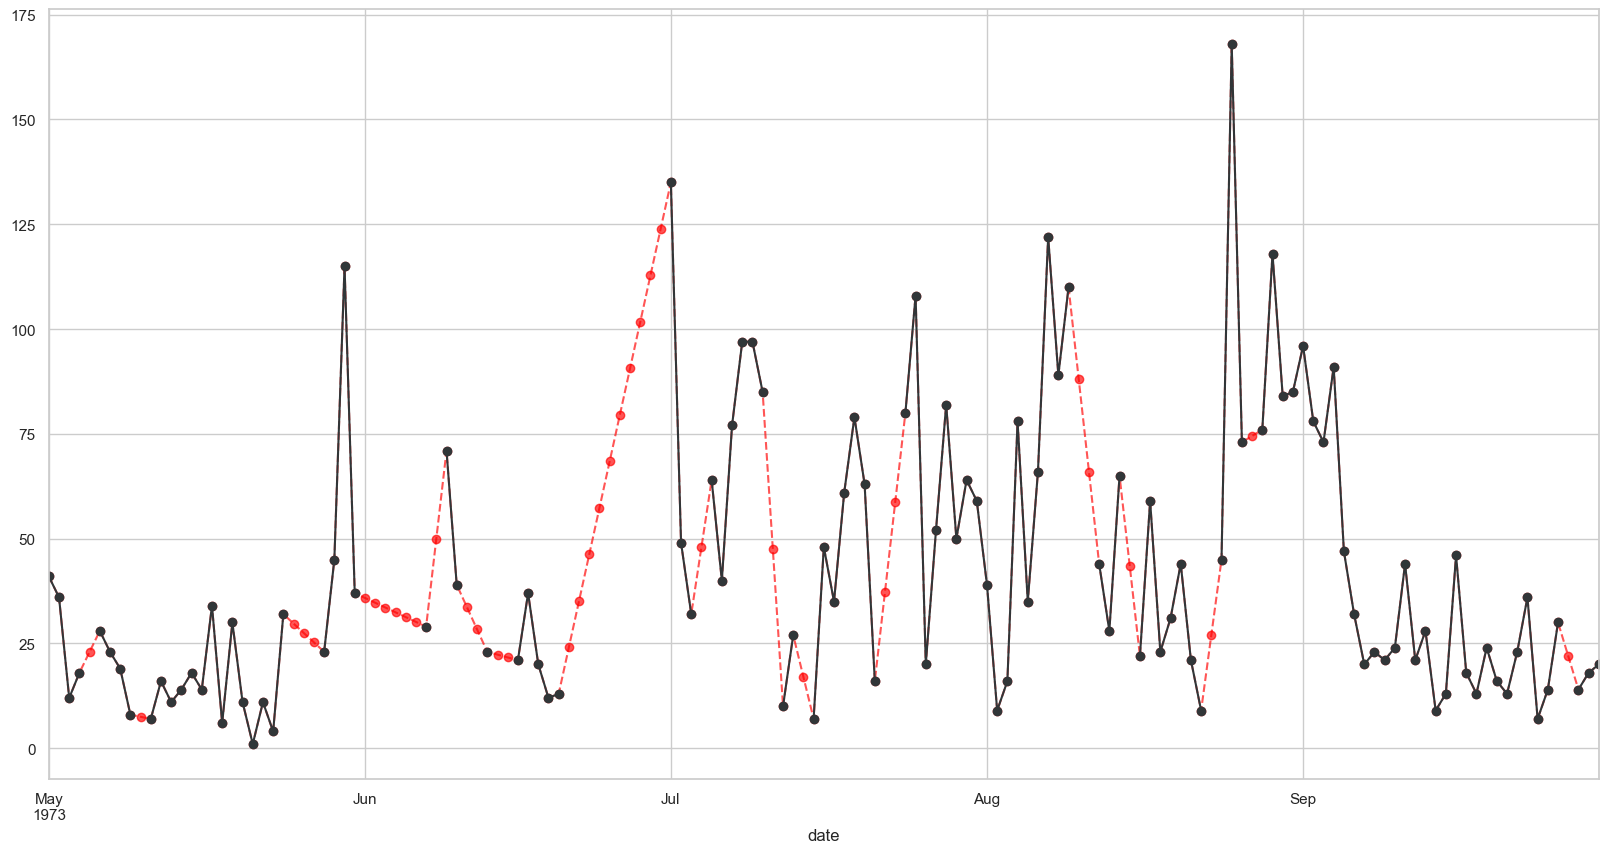

In [45]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='linear').plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

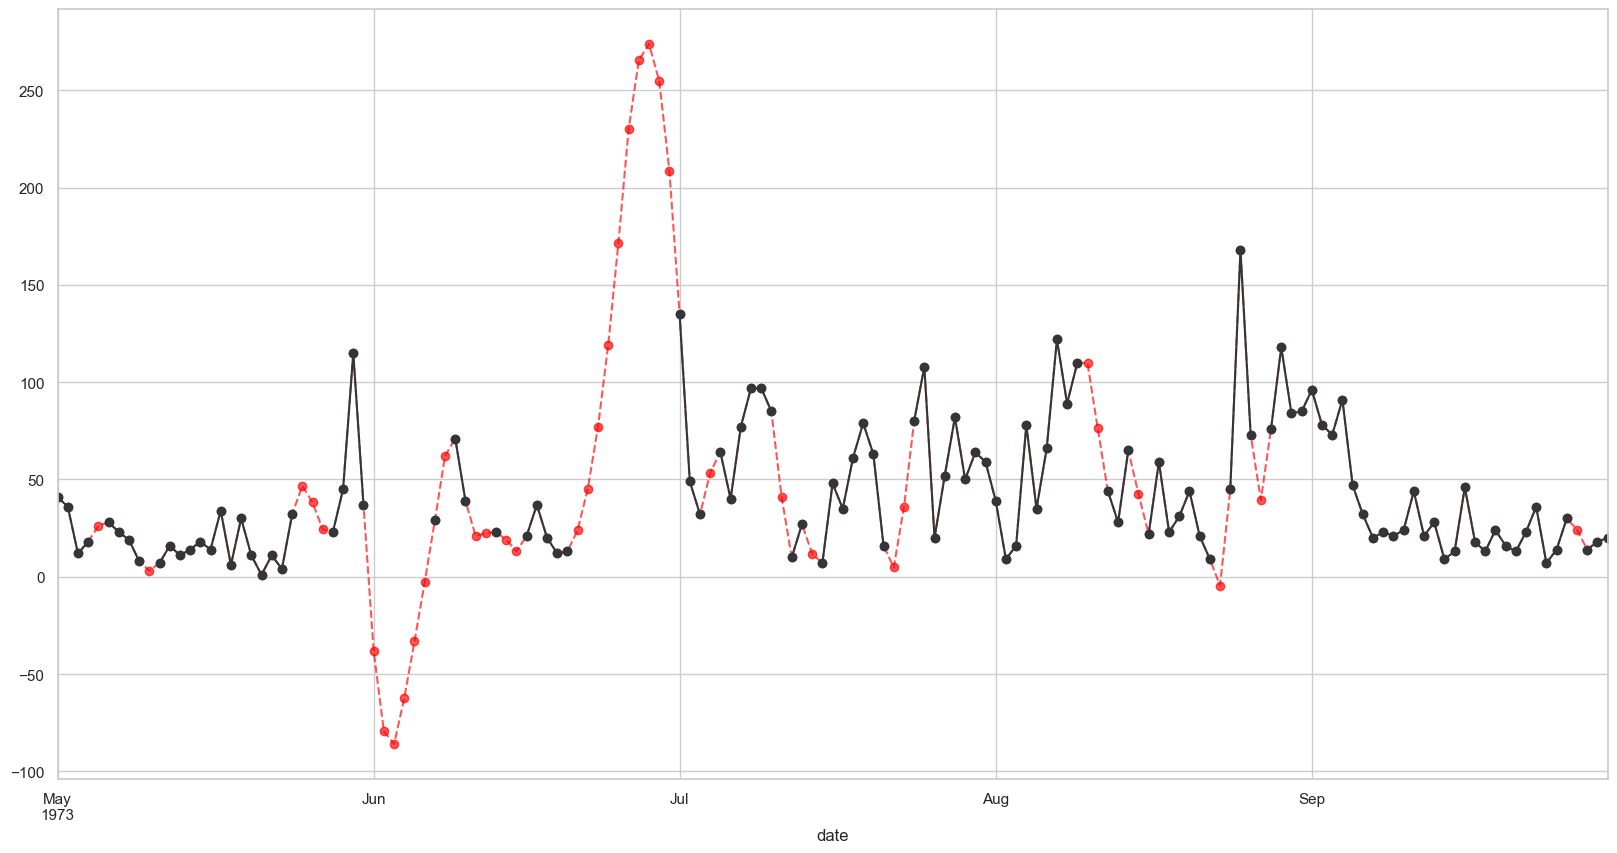

In [46]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='quadratic').plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

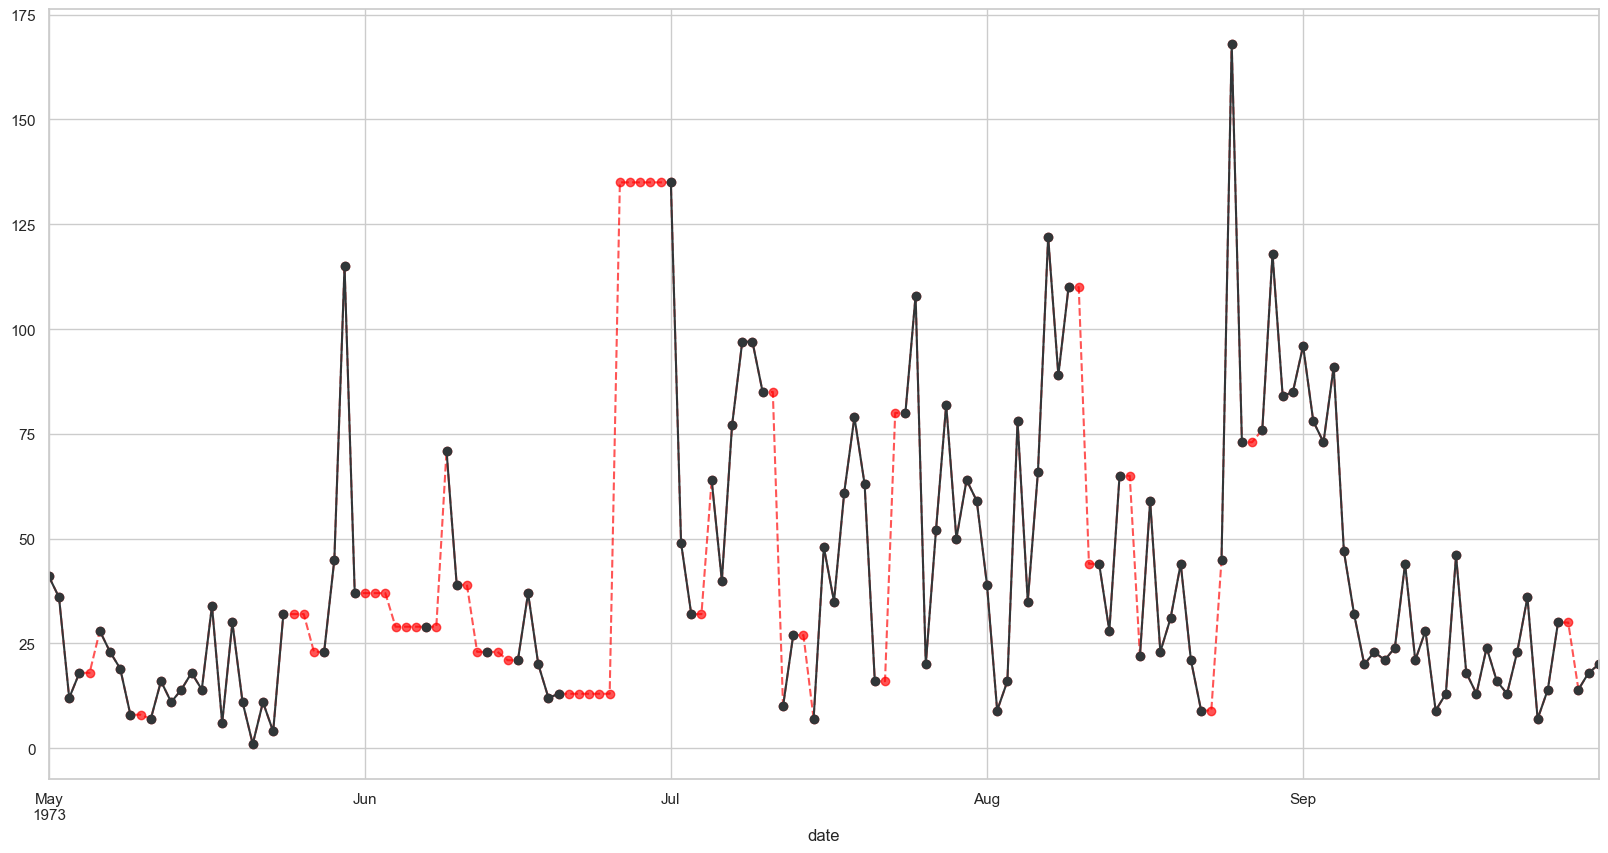

In [47]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='nearest').plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

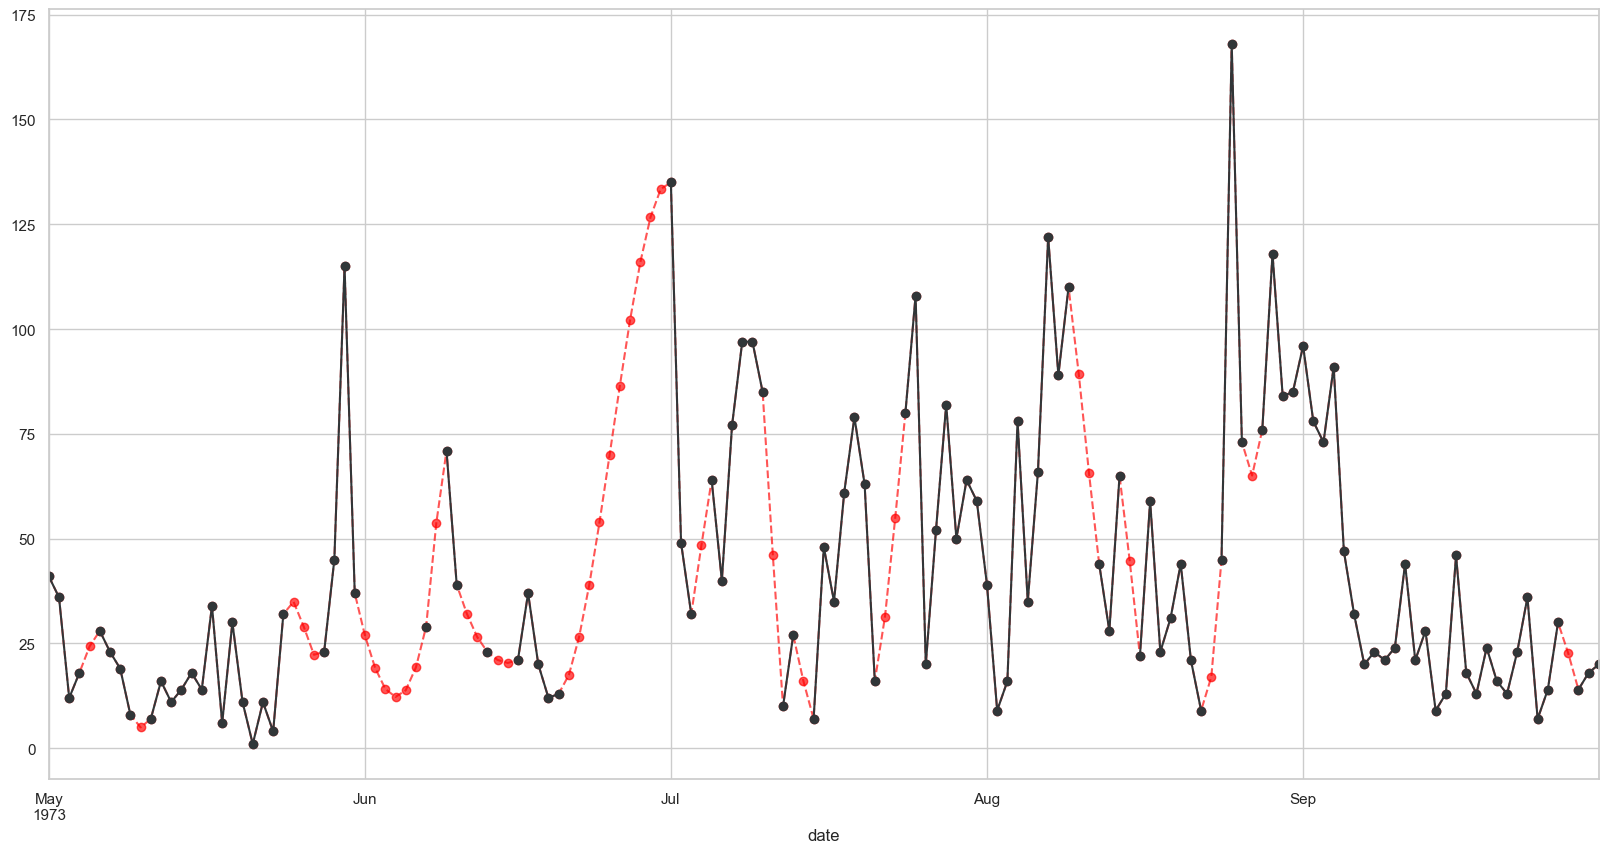

In [48]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='akima').plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

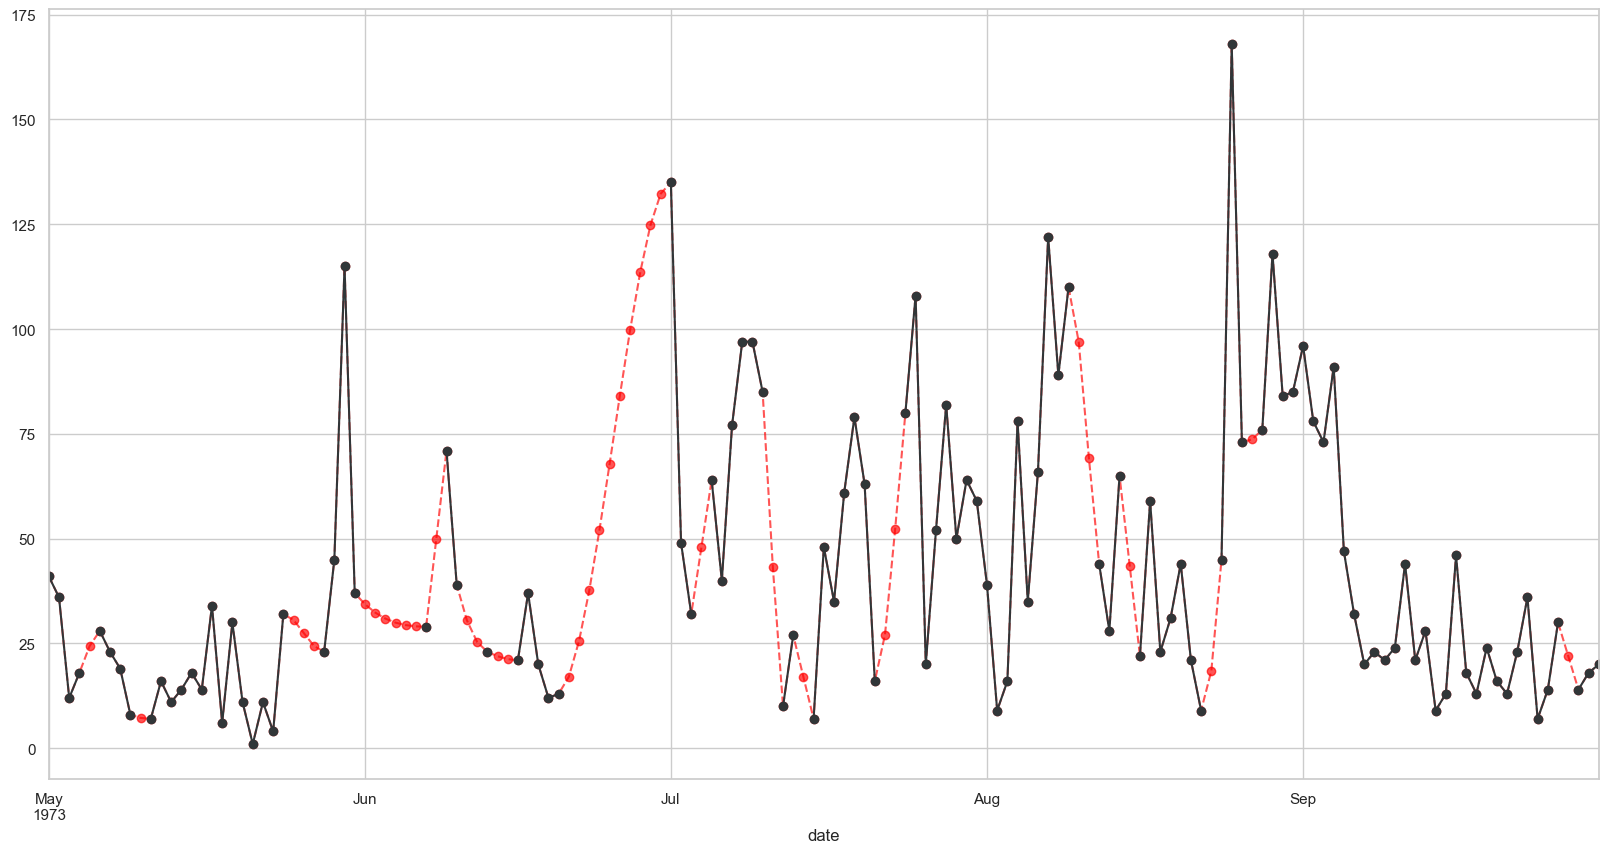

In [49]:
plt.figure(figsize=(20,10))
(
    aq_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='pchip').plot(color='red', marker='o', alpha=6/9, linestyle='dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

In [50]:
aq_df['ozone'].interpolate(method='linear')

date
1973-05-01    41.0
1973-05-02    36.0
1973-05-03    12.0
1973-05-04    18.0
1973-05-05    23.0
              ... 
1973-09-26    30.0
1973-09-27    22.0
1973-09-28    14.0
1973-09-29    18.0
1973-09-30    20.0
Name: ozone, Length: 153, dtype: float64

In [51]:
aq_df['ozone'] = aq_df['ozone'].interpolate(method='linear')
aq_df['ozone']

date
1973-05-01    41.0
1973-05-02    36.0
1973-05-03    12.0
1973-05-04    18.0
1973-05-05    23.0
              ... 
1973-09-26    30.0
1973-09-27    22.0
1973-09-28    14.0
1973-09-29    18.0
1973-09-30    20.0
Name: ozone, Length: 153, dtype: float64

<Axes: xlabel='date'>

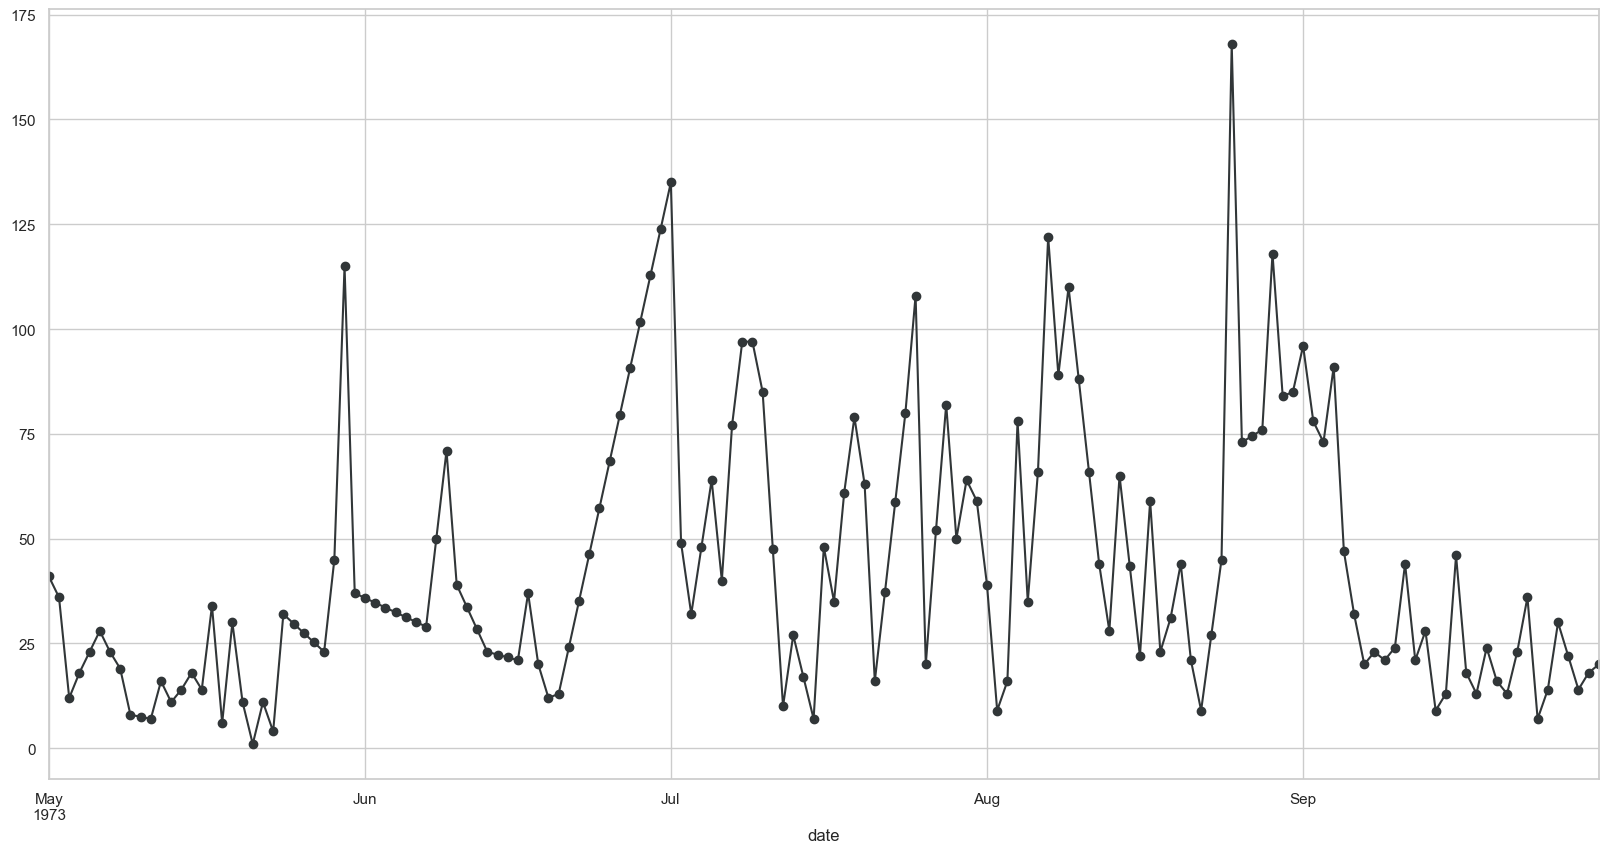

In [52]:
plt.figure(figsize=(20,10))
aq_df['ozone'].plot(color='#313638', marker='o')

## Imputación por KNN
> Algoritmo de vecinos más cercanos

In [53]:
nhanes_df.head()

,SEQN,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
0,93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
1,93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
2,93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
3,93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
4,93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


In [54]:
nhanes_transformed_df.head()

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0


In [55]:
nhanes_transformed_df2.head()

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0


In [56]:
# Imputador 
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[: , :] = knn_imputer.fit_transform(nhanes_df_knn).round()
nhanes_df_knn

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,68.0,157.0,189.0,100.0,0.0,13.0
3,2.0,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,66.0,173.0,150.0,74.0,0.0,14.0


In [57]:
(
    pd.concat(
        [nhanes_df_knn,
         nhanes_df.missing.create_shadow_matrix(True, False, only_missing=True)
        ],
        axis=1
    )
)

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
2,2.0,1.0,93707.0,68.0,157.0,189.0,100.0,0.0,13.0,True,True,False,False,False
3,2.0,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False
7155,4.0,0.0,102955.0,66.0,173.0,150.0,74.0,0.0,14.0,True,True,False,False,False


### Ordenamiento por cantidad de variables faltantes

In [58]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10)

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, only_missing=True)
        ],
        axis=1
    )
)

,gender,SEQN,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
0,0.0,93705.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0,False,False,False,False,False
1,1.0,93706.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0,False,False,False,False,False
2,1.0,93707.0,0.0,13.0,100.0,189.0,2.0,168.0,67.0,True,True,False,False,False
3,0.0,93709.0,0.0,75.0,74.0,176.0,3.0,200.0,62.0,False,False,True,False,False
4,1.0,93711.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,1.0,102949.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0,False,False,False,False,False
7153,1.0,102953.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0,False,False,False,False,False
7154,0.0,102954.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0,False,False,False,False,False
7155,0.0,102955.0,0.0,14.0,74.0,150.0,4.0,178.0,66.0,True,True,False,False,False


## Imputación basada en modelos

In [59]:
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'age')
    .sort_values(by='height')
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        only_missing=True
    )
)

,height,weight,gender,age,height_NA
966,49.0,158.0,Female,80.0,False
2194,50.0,170.0,Female,46.0,False
3251,50.0,80.0,Female,29.0,False
6709,51.0,177.0,Female,71.0,False
90,53.0,146.0,Female,80.0,False
...,...,...,...,...,...
7132,NaN,107.0,Female,14.0,True
7140,NaN,107.0,Female,15.0,True
7145,NaN,107.0,Female,14.0,True
7148,NaN,107.0,Male,15.0,True


In [60]:
nhanes_model_df = (
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'age')
    .sort_values(by='height')
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        only_missing=True
    )
)

nhanes_model_df

,height,weight,gender,age,height_NA
966,49.0,158.0,Female,80.0,False
2194,50.0,170.0,Female,46.0,False
3251,50.0,80.0,Female,29.0,False
6709,51.0,177.0,Female,71.0,False
90,53.0,146.0,Female,80.0,False
...,...,...,...,...,...
7132,NaN,107.0,Female,14.0,True
7140,NaN,107.0,Female,15.0,True
7145,NaN,107.0,Female,14.0,True
7148,NaN,107.0,Male,15.0,True


In [61]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols('height ~ weight + gender + age', data= df )
    )
    .fit()
)
height_ols

In [62]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)
ols_imputed_values

2       69.0
12      64.0
22      64.0
24      69.0
25      69.0
        ... 
7132    63.0
7140    63.0
7145    63.0
7148    68.0
7155    63.0
Length: 1669, dtype: float64

In [63]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values

## Imputaciones múltiples por ecuaciones encadenadas (MICE)

In [64]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())
mice_imputer

IterativeImputer(estimator=BayesianRidge())

In [65]:
nhanes_mice_df = nhanes_transformed_df.copy(deep = True)
nhanes_mice_df

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,NaN,NaN,150.0,74.0,0.0,14.0


In [66]:
nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_mice_df).round()
nhanes_mice_df

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,69.0,179.0,189.0,100.0,0.0,13.0
3,2.0,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,65.0,170.0,150.0,74.0,0.0,14.0


In [67]:
nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, only_missing=True)
    ],
    axis = 1
)
nhanes_mice_df

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
2,2.0,1.0,93707.0,69.0,179.0,189.0,100.0,0.0,13.0,True,True,False,False,False
3,2.0,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False
7155,4.0,0.0,102955.0,65.0,170.0,150.0,74.0,0.0,14.0,True,True,False,False,False


In [72]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending'
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age
0,2.0,0.0,93705.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,93706.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,93707.0,69.0,179.0,189.0,100.0,0.0,13.0
3,2.0,0.0,93709.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,93711.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...
7152,0.0,1.0,102949.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,102953.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,102954.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,102955.0,65.0,170.0,150.0,74.0,0.0,14.0


## Transformación inversa de los datos

In [68]:
nhanes_imputated_df = nhanes_mice_df.copy(deep=True)

nhanes_imputated_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputated_df

,general_health_condition,gender,SEQN,height,weight,total_cholesterol,pulse,diabetes,age,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
0,Good,Female,93705.0,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
1,Very good,Male,93706.0,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
2,Good,Male,93707.0,69.0,179.0,189.0,100.0,0.0,13.0,True,True,False,False,False
3,Good,Female,93709.0,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False
4,Very good,Male,93711.0,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,Excellent,Male,102949.0,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False
7153,Fair or,Male,102953.0,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
7154,Good,Female,102954.0,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False
7155,Very good,Female,102955.0,65.0,170.0,150.0,74.0,0.0,14.0,True,True,False,False,False


In [69]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [70]:
nhanes_imputated_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [71]:
nhanes_mice_df.missing.number_missing()

0